# Spherical divergence correction

The signal from the source fades over time but is impossible to analysing the seismogramms with low amplitude signals. In propose to increase the signal's amplitude we introduce the correction function. This function will restore the amplitude values for the entire field.

* [Dataset](#Dataset)
* [Model description](#Model-description)
* [Methods of sperical divergence correction](#Methods-of-sperical-divergence-correction)
    * [1. Manual tuning](#1.-Manual-tuning)
    * [2. Minimizing the loss function](#2.-Minimizing-the-loss-function)
* [Metrics](#Metrics)
* [Running time](#Running-time)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

## Dataset
We are using the dataset with spherical divergence problem. This dataset has detailed description [here](../../datasets/spherical_divergence_correction.ipynb). There are many examples of corrected seismograms contains in this dataset. In purpoce to show the quality of our model we will use only raw data and corrected data with parameters v=2 and t=1.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../..')

from seismicpro.batchflow import Pipeline, V, D
from seismicpro.src import (SeismicBatch, FieldIndex, seismic_plot,
                            gain_plot, calculate_sdc_quality,
                            measure_gain_amplitude, SeismicDataset)
from seismicpro.models import calc_derivative_diff

Index field records:

In [2]:
path_raw = '/notebooks/anton/sphere_difference/2_TAR_raw.sgy'
path_corr = '/notebooks/anton/sphere_difference/2_TAR_v2_t1.sgy'

field_index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw).
               merge(FieldIndex(name='target', path=path_corr)))
field_index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,target,target
FieldRecord,,,,,,
3237,3075,1,1,/notebooks/anton/sphere_difference/2_TAR_raw.sgy,1,/notebooks/anton/sphere_difference/2_TAR_v2_t1...
3237,3030,2,2,/notebooks/anton/sphere_difference/2_TAR_raw.sgy,2,/notebooks/anton/sphere_difference/2_TAR_v2_t1...
3237,2984,3,3,/notebooks/anton/sphere_difference/2_TAR_raw.sgy,3,/notebooks/anton/sphere_difference/2_TAR_v2_t1...
3237,2940,4,4,/notebooks/anton/sphere_difference/2_TAR_raw.sgy,4,/notebooks/anton/sphere_difference/2_TAR_v2_t1...
3237,2895,5,5,/notebooks/anton/sphere_difference/2_TAR_raw.sgy,5,/notebooks/anton/sphere_difference/2_TAR_v2_t1...



## Model description
The process when the amplitude of the signal on the seigmograms decreases with time named _spherical divergence_. To compensate this process the correction function - $g(t)$ is introduced and is determined by equation:
$$ g(t) = \frac{V_{rms}^{v_{pow}}(t) * t^{t_{pow}}}{V_0} \ where, $$
* $V_{rms}(t)$ - root mean square speed.
* t - time.
* $V_0$ - speed at time 0.
Here is $V_{pow}$ and $t_{pow}$ hyperparameters.

Then new amplitude value calculated as:
$$A_{new}(t) = A(t) * g(t)$$

We'll use predefined speed that was obtained by a specialist.

In [3]:
speed = np.array([1524]*700 + [1924.5]*300 + [2184.0]*400 +  [2339.6]*400 + 
                 [2676]*150 + [2889.5]*2250 + [3566]*2800 + [4785.3]*1000)

## Methods of sperical divergence correction

There are two oppunities to correct sperical divergence:
* Run spherical divergence correction with own values to hyperparameters.
* Find this hyperparameters with a built-in optimizer and use this parameters for all dataset.
In this notebook each of them will be described separately.

### 1. Manual tuning

For manual tuning is used ```correct_spherical_divergence``` action. To use own parameters you have to determine ```params``` variable.

In [4]:
%%time
ix = 1
manual_batch = (SeismicDataset(field_index, SeismicBatch).next_batch(2)
                .load(fmt='segy', components=('raw', 'target'), tslice=slice(3000))
                .sort_traces(src=('raw', 'target'), dst=('raw', 'target'), sort_by='offset')
                .correct_spherical_divergence(src='raw', dst='corrected',
                                              speed=speed, params=(2, 1))
)

CPU times: user 784 ms, sys: 300 ms, total: 1.08 s
Wall time: 922 ms


It will be useful to look at the difference between the original seismogram and the corrected one.

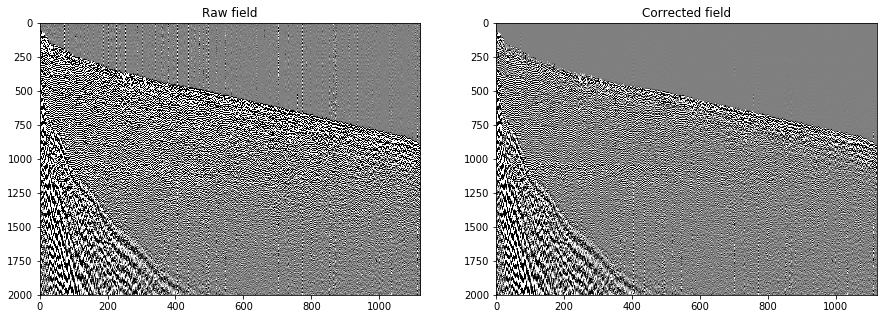

In [5]:
cv = 0.1
seismic_plot([manual_batch.raw[ix], manual_batch.corrected[ix]], vmin=-cv, vmax=cv,
             cmap='gray', figsize=(15, 5), names=['Raw field', 'Corrected field'])

More clear this difference shown on gain plot. The following plot shows the ratio of the amplitude value at time t to the maximum amplitude. Our goal is to straighten this line up.

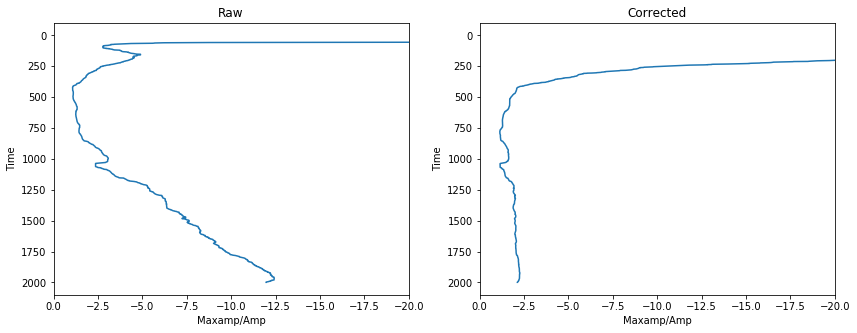

In [6]:
gain_plot([manual_batch.raw[ix], manual_batch.corrected[ix]], 51, names=['Raw', 'Corrected'],
          figsize=(14, 5), xlim=(0, -20))

It's clear that the difference has narrowed since the correction was made. What about difference between corrected line and target?

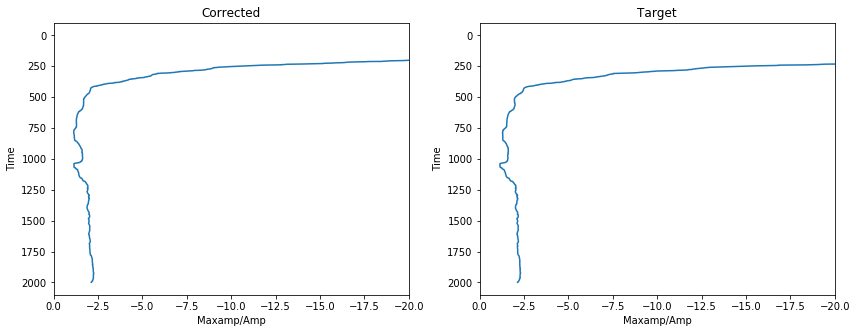

In [7]:
gain_plot([manual_batch.corrected[ix], manual_batch.target[ix]], 51, names=['Corrected', 'Target'],
          figsize=(14, 5), xlim=(0, -20))

They look very similar.

### 2. Minimizing the loss function
In order to find parameters for spherical divergence correction one can use ```find_correctoin_parameters``` function from ```SeismicDataset```. Then the optimal parameters will be found by optimizing loss function based on the first field and the resulted parameters will save to attribute with name ```correction_params```. If you want to save found parameters to your own container, use ```save_to``` argument.

Before we start to optimization process, we have to determine a dataset instance.

In [8]:
dataset = SeismicDataset(field_index, SeismicBatch)

The whole optimization process will take place before the main pipeline and will be taken to the main part by dataset or by pipeline variable. To show the process more clearly calculated parameters will be taken from pipeline variable named ```params```.

In [9]:
pipeline = (Pipeline()
            .load(fmt='segy', components='raw', tslice=slice(3000))
            .sort_traces(src='raw', dst='raw', sort_by='offset')
            .correct_spherical_divergence(src='raw', dst='corrected',
                                          speed=speed, params=V('params'))
            .run_later(1, n_iters=1)
) << dataset

To optimize parameters once dataset's function determine in before pipeline instance.

In [10]:
(pipeline.before
          .add_namespace(SeismicDataset)
          .find_correctoin_parameters(src='raw', speed=speed, 
                                      loss=calculate_sdc_quality, started_point=(2, 1),
                                      save_to=V('params'))
);

Let's create pipeline, run it and get batch from it!

In [11]:
%%time
pipeline.run()

CPU times: user 29.3 s, sys: 72 ms, total: 29.4 s
Wall time: 29.4 s


In [12]:
optimal_batch = pipeline.next_batch(1)

Resulted params now are stored in dataset's attrubte with name ```correction_params```.

In [13]:
print('Optimal parameters for v_pow is {:.3}, for t_pow is {:.3} from correction_params.'.format(*dataset.correction_params))

Optimal parameters for v_pow is 2.06, for t_pow is 0.998 from correction_params.


And in the pipeline's variable.

In [14]:
print("Optimal parameters for v_pow is {:.3}, for t_pow is {:.3} from pipeline's variable.".format(*pipeline.v('params')))

Optimal parameters for v_pow is 2.06, for t_pow is 0.998 from pipeline's variable.


Sesimograms before and after correction.

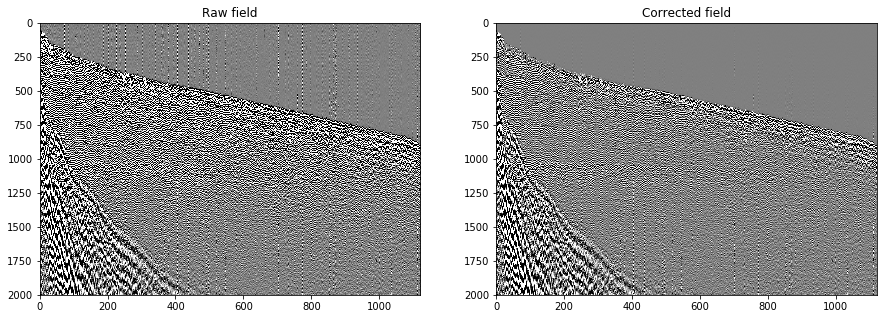

In [15]:
seismic_plot([optimal_batch.raw[0], optimal_batch.corrected[0]], vmin=-cv, vmax=cv,
              cmap='gray', figsize=(15, 5), names=['Raw field', 'Corrected field'])

Graph of the amplitude difference between raw and corrected data with optimal parameters.

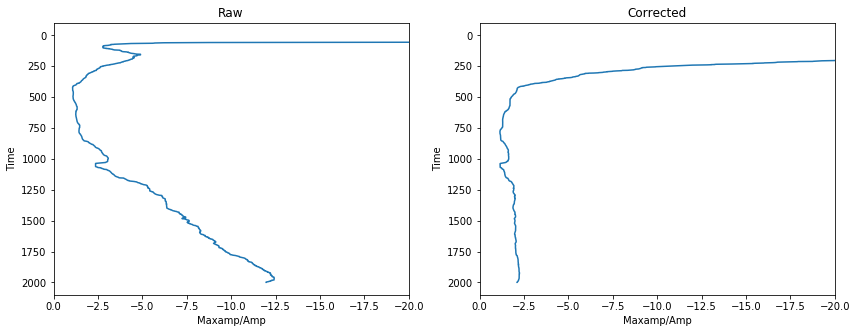

In [16]:
gain_plot([optimal_batch.raw[0], optimal_batch.corrected[0]], 51, names=['Raw', 'Corrected'],
          figsize=(14, 5), xlim=(0, -20))


## Metrics

In prupose to measure the model's quality the following metrics are introduced:
1. Gain plot.

    Gain's graph plots the ratio of the maximum mean value of the amplitude to the mean value of the smoothed amplitude at the moment t.
2. L1.
3. Derivative metric.

    This metric measures meduan of the difference between the first-order derivative module of two adjacent points.

Let's calcualte the difference between this graphs and calculate the metric.

In [17]:
manual = manual_batch.corrected[ix]
target = manual_batch.target[ix]
raw = manual_batch.raw[ix]

print('L1 measure: {:.3}'.format(np.mean(np.abs(manual - target))))
print('DM for raw field: {:.3}'.format(calc_derivative_diff(raw)))
print('DM for manual corr: {:.3}'.format(calc_derivative_diff(manual)))
print('DM for target corr: {:.3}'.format(calc_derivative_diff(target)))

L1 measure: 0.00433
DM for raw field: 0.00613
DM for manual corr: 0.00223
DM for target corr: 0.00241


One can notice that the L1 between our implementation is very low. And for both of them the DM so same little.

Let's do the save for field corrected with optimal parameters. Does not make sence to measure L1 distance between target and corrected traces because of the different parameters, so we'll measue only DM metric.

In [18]:
manual_corr = np.concatenate(optimal_batch.corrected)
raw_corr = np.concatenate(optimal_batch.raw)
print('DM for raw field: {:.3}'.format(calc_derivative_diff(raw_corr)))
print('DM for corrected field with'\
      ' optimal parameters: {:.3}'.format(calc_derivative_diff(manual_corr)))

DM for raw field: 0.00613
DM for corrected field with optimal parameters: 0.00217


We can see that the value of the metric has decreased by more than 2 times with optimal parameters. And based on this metric with found parameters correction works better.

## Running time

For Intel i7 we obtain:
* for given parameters with batch size 1 is 520 ms
* finding an optimal parameters with batch size 1 is 30 seconds on average.

## Criticism
* Function for optimizing may not fully reflect the desired behavior of the gain plot.
* The function is very slow to find the optimum parameters.

## Conclusion
This notebooks shows that the correction's methods shows a good quality sometimes even better then the real data. Also we introduce the function that could be used to optimize the parameters for correction of spherical divergence.

## Suggestions for improvements
Increase the speed of finding the optimal parameters.